In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import time

In [3]:
# load and preprocess the image
def load_and_preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (1280, 720))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray_image

# subtract images
def subtract_images(image1, image2):
    diff = cv2.absdiff(image1, image2)
    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
    return diff, thresh

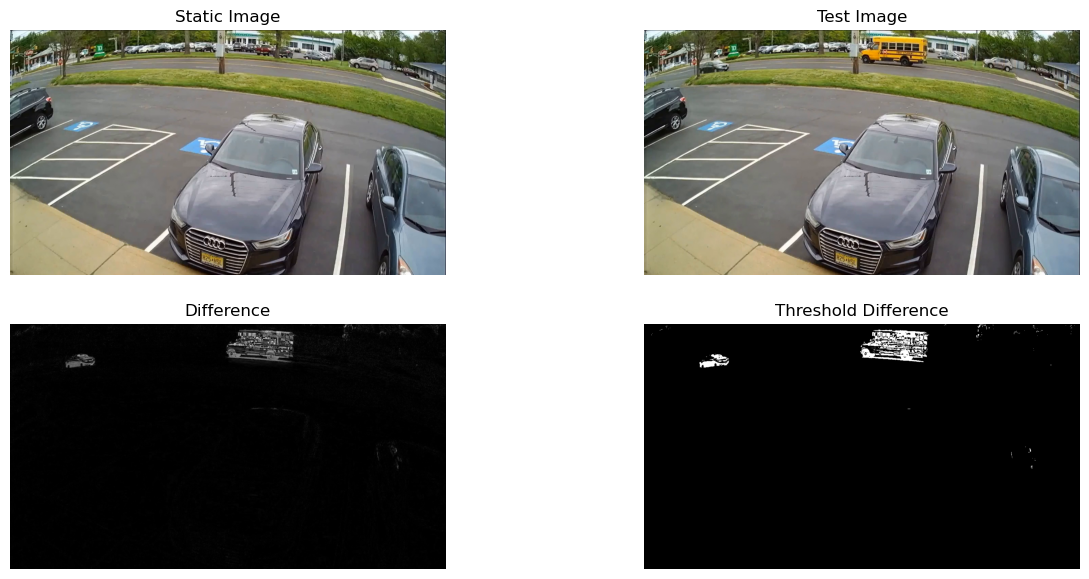

In [4]:
image_path1 = 'static.png'
image_path2 = 'test.png'

image1, gray_image1 = load_and_preprocess(image_path1)
image2, gray_image2 = load_and_preprocess(image_path2)

# subtract the images
diff, thresh = subtract_images(gray_image1, gray_image2)

# plot the images
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.title('Static Image')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Test Image')
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Difference')
plt.imshow(diff, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Threshold Difference')
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.show()

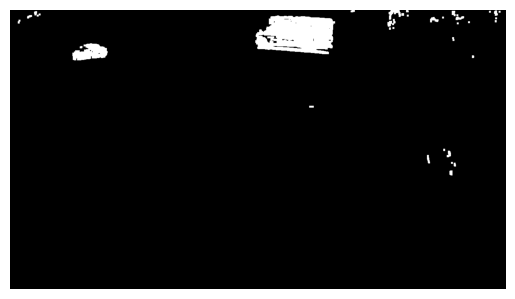

In [5]:
dilated_image = cv2.dilate(thresh, None, iterations=2)
plt.imshow(dilated_image, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
cnts = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [7]:
for c in cnts:
    if cv2.contourArea(c) < 700:
        continue

    # get the bounding box coordinates
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(image2, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow('test', image2)
cv2.waitKey(10000)
cv2.destroyAllWindows()

2025-03-23 13:19:56.516 python[84416:2056301] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-23 13:19:56.516 python[84416:2056301] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [6]:
import cv2
import imutils
import time
import numpy as np

# Define subtract_images function if it's not already defined elsewhere
def subtract_images(image1, image2):
    diff = cv2.absdiff(image1, image2)
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
    return diff, thresh

video_path = 'test.mp4'
video_cap = cv2.VideoCapture(video_path)
static_frame = None

# Define the ROI in the center of the frame
def get_center_roi(frame, roi_width_percent=0.4, roi_height_percent=0.4):
    height, width = frame.shape[:2]
    
    # Calculate ROI dimensions
    roi_width = int(width * roi_width_percent)
    roi_height = int(height * roi_height_percent)
    
    # Calculate top-left corner of ROI
    x = (width - roi_width) // 2
    y = (height - roi_height) // 2
    
    return (x, y, roi_width, roi_height)

try:
    while True:
        success, frame = video_cap.read()
        if not success:
            print("End of video or failed to read frame")
            break

        frame = cv2.resize(frame, (1280, 720))
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Get ROI coordinates
        # roi_x, roi_y, roi_width, roi_height = get_center_roi(frame)
        roi_x, roi_y, roi_width, roi_height = (625, 0, 200, 150)
        
        # Draw ROI rectangle
        cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (0, 0, 255), 2)

        if static_frame is None:
            static_frame = gray_frame
            continue

        # get the subtract frames
        diff, thresh = subtract_images(static_frame, gray_frame)
        # dilated_image = cv2.dilate(thresh, None, iterations=2)

        # get contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        motion_in_roi = False
        
        # iterate the contours
        for c in cnts:
            if cv2.contourArea(c) < 700:
                continue
        
            # get the bounding box coordinates
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Check if the contour intersects with the ROI
            roi_rect = (roi_x, roi_y, roi_width, roi_height)
            contour_rect = (x, y, w, h)
            
            # Determine if there's an intersection between the contour and ROI
            if (x < roi_x + roi_width and x + w > roi_x and 
                y < roi_y + roi_height and y + h > roi_y):
                # Highlight contours inside ROI in green
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                motion_in_roi = True
            else:
                # Draw other contours in blue
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)

        if motion_in_roi:
            # print("Motion detected in ROI")
            # Add text to the frame
            cv2.putText(frame, "MOTION DETECTED", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        cv2.imshow("Motion Detection", frame)

        # Better key press handling - wait for 100ms
        key = cv2.waitKey(100) & 0xFF
        if key == 27 or key == ord('q'):  # ESC or 'q' key
            print("User requested exit")
            break
            
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Always ensure proper cleanup
    print("Cleaning up resources")
    video_cap.release()
    cv2.destroyAllWindows()
    # Force close any remaining windows (sometimes needed in notebooks)
    for i in range(1, 5):
        cv2.waitKey(1)

2025-03-23 13:20:48.672 python[84793:2057798] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-23 13:20:48.672 python[84793:2057798] +[IMKInputSession subclass]: chose IMKInputSession_Modern


User requested exit
Cleaning up resources


In [7]:
import cv2
import imutils
import time
import numpy as np

video_path = 'test.mp4'
video_cap = cv2.VideoCapture(video_path)
static_frame = None

# Motion detection parameters - easily adjustable
THRESHOLD_VALUE = 50      # Lower = more sensitive, Higher = less sensitive
MIN_AREA = 700            # Minimum contour area to consider
DILATION_ITERATIONS = 1   # Fewer iterations = less sensitivity
BLUR_SIZE = (5, 5)        # Blur kernel size for noise reduction
ROI_WIDTH_PERCENT = 0.4   # ROI width as percentage of frame
ROI_HEIGHT_PERCENT = 0.4  # ROI height as percentage of frame

try:
    # Read first frame to get dimensions
    success, frame = video_cap.read()
    if not success:
        print("Failed to read from video source")
        exit()
        
    frame = cv2.resize(frame, (1280, 720))
    height, width = frame.shape[:2]
    
    # Define ROI coordinates
    # roi_width = int(width * ROI_WIDTH_PERCENT)
    # roi_height = int(height * ROI_HEIGHT_PERCENT)
    # roi_x = (width - roi_width) // 2
    # roi_y = (height - roi_height) // 2
    roi_x, roi_y, roi_width, roi_height = (625, 0, 200, 150)
    # roi = (roi_x, roi_y, roi_width, roi_height)
    
    # Reset video
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    while True:
        success, frame = video_cap.read()
        if not success:
            print("End of video or failed to read frame")
            break

        frame = cv2.resize(frame, (1280, 720))
        
        # Extract the ROI for processing
        roi_frame = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
        
        # Convert ROI to grayscale and apply blur to reduce noise
        gray_roi = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)
        gray_roi = cv2.GaussianBlur(gray_roi, BLUR_SIZE, 0)

        if static_frame is None:
            static_frame = gray_roi.copy()
            continue

        # Calculate absolute difference between current ROI and static frame
        frame_delta = cv2.absdiff(static_frame, gray_roi)
        
        # Apply threshold to get binary image
        thresh = cv2.threshold(frame_delta, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)[1]
        
        # Optional: Apply dilation to fill in holes
        if DILATION_ITERATIONS > 0:
            thresh = cv2.dilate(thresh, None, iterations=DILATION_ITERATIONS)

        # Find contours in the thresholded image
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        motion_detected = False
        
        # Draw the ROI rectangle on the main frame
        cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (0, 0, 255), 2)

        # Process contours within the ROI
        for c in cnts:
            # Filter contours by area
            if cv2.contourArea(c) < MIN_AREA:
                continue
                
            # Get bounding box and draw on the ROI frame
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(roi_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            motion_detected = True
        
        # Display detection status
        if motion_detected:
            print("Motion detected in ROI")
            cv2.putText(frame, "MOTION DETECTED", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        # Show frames
        cv2.imshow("Motion Detection", frame)
        cv2.imshow("ROI Threshold", thresh)  # Show threshold image for debugging
        
        # Key handling
        key = cv2.waitKey(100) & 0xFF
        if key == 27 or key == ord('q'):  # ESC or 'q' key
            print("User requested exit")
            break
            
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Cleanup
    print("Cleaning up resources")
    video_cap.release()
    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)

Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
Motion detected in ROI
User requested exit
Cleaning up resources


In [8]:
import cv2
import imutils
import time
import numpy as np

video_path = 'test_cars.mp4'
video_cap = cv2.VideoCapture(video_path)

# Motion detection parameters - easily adjustable
THRESHOLD_VALUE = 80       # Start with a lower threshold for vehicle detection
MIN_AREA = 400             # Lower to catch smaller vehicles/partial vehicles
DILATION_ITERATIONS = 1    # Keep minimal dilation
BLUR_SIZE = (7, 7)         # Increase blur to reduce noise
ROI_X, ROI_Y = 400, 200    # From your example
ROI_WIDTH, ROI_HEIGHT = 500, 150  # From your example
HISTORY_FRAMES = 50        # For background subtractor

try:
    # Read first frame to get dimensions
    success, frame = video_cap.read()
    if not success:
        print("Failed to read from video source")
        exit()
        
    frame = cv2.resize(frame, (1920, 1080))
    
    # Create a background subtractor
    # History: number of frames to build background model
    # VarThreshold: threshold for detecting foreground
    # DetectShadows: whether to detect and mark shadows
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=HISTORY_FRAMES, 
        varThreshold=50, 
        detectShadows=False
    )
    
    # Skip some initial frames to let background model stabilize
    for _ in range(10):
        success, frame = video_cap.read()
        if not success:
            break
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
        bg_subtractor.apply(roi_frame)
    
    # Counter for vehicle detection
    vehicle_count = 0
    last_detection_time = time.time()
    
    while True:
        success, frame = video_cap.read()
        if not success:
            print("End of video or failed to read frame")
            break

        frame = cv2.resize(frame, (1920, 1080))
        
        # Extract the ROI for processing
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(roi_frame)
        
        # Apply additional processing to the foreground mask
        fg_mask = cv2.GaussianBlur(fg_mask, BLUR_SIZE, 0)
        _, thresh = cv2.threshold(fg_mask, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
        
        # Optional: Apply dilation to fill in holes
        if DILATION_ITERATIONS > 0:
            thresh = cv2.dilate(thresh, None, iterations=DILATION_ITERATIONS)
            thresh = cv2.erode(thresh, None, iterations=1)  # Add erosion to reduce noise

        # Find contours in the thresholded image
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        motion_detected = False
        current_time = time.time()
        
        # Draw the ROI rectangle on the main frame
        cv2.rectangle(frame, (ROI_X, ROI_Y), (ROI_X + ROI_WIDTH, ROI_Y + ROI_HEIGHT), (0, 0, 255), 2)

        # Process contours within the ROI
        for c in cnts:
            # Filter contours by area
            contour_area = cv2.contourArea(c)
            if contour_area < MIN_AREA:
                continue
                
            # Get bounding box and draw on the ROI frame
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Additional filtering - aspect ratio check for vehicles
            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 3.0:
                continue  # Skip objects with unusual aspect ratios
                
            cv2.rectangle(roi_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            motion_detected = True
            
            # Add contour area as text
            cv2.putText(roi_frame, f"Area: {contour_area:.0f}", (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Display detection status
        if motion_detected:
            # Only count a new vehicle if enough time has passed since last detection
            if current_time - last_detection_time > 0.5:  # 500ms debounce time
                vehicle_count += 1
                last_detection_time = current_time
                
            cv2.putText(frame, "VEHICLE DETECTED", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        # Show vehicle count
        cv2.putText(frame, f"Vehicle Count: {vehicle_count}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        
        # Show frames
        cv2.imshow("Motion Detection", frame)
        cv2.imshow("ROI Threshold", thresh)  # Show threshold image for debugging
        
        # Key handling
        key = cv2.waitKey(100) & 0xFF
        if key == 27 or key == ord('q'):  # ESC or 'q' key
            print("User requested exit")
            break
            
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Cleanup
    print("Cleaning up resources")
    video_cap.release()
    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)

User requested exit
Cleaning up resources


# Testing

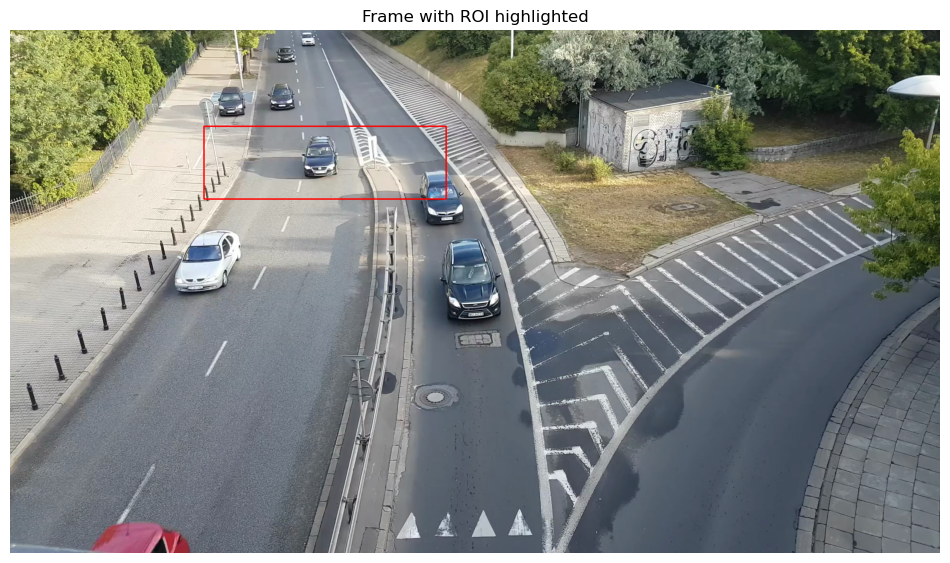

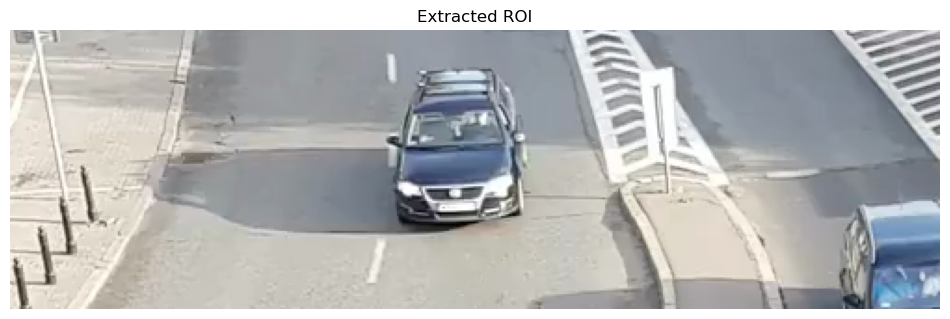

True

In [3]:
import cv2
import imutils
import time
import numpy as np
import matplotlib.pyplot as plt

# You'll need to change this to your video path
video_path = 'test_cars.mp4'
video_cap = cv2.VideoCapture(video_path)

# Region of interest coordinates
ROI_X, ROI_Y = 400, 200
ROI_WIDTH, ROI_HEIGHT = 500, 150

# Read a sample frame to show the ROI
success, frame = video_cap.read()
if success:
    frame = cv2.resize(frame, (1920, 1080))
    
    # Draw ROI rectangle
    roi_display = frame.copy()
    cv2.rectangle(roi_display, (ROI_X, ROI_Y), 
                 (ROI_X + ROI_WIDTH, ROI_Y + ROI_HEIGHT), (0, 0, 255), 2)
    
    # Display frame with ROI
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
    plt.title("Frame with ROI highlighted")
    plt.axis('off')
    plt.show()
    
    # Extract and display just the ROI
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
    plt.title("Extracted ROI")
    plt.axis('off')
    plt.show()
else:
    print("Could not read video")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

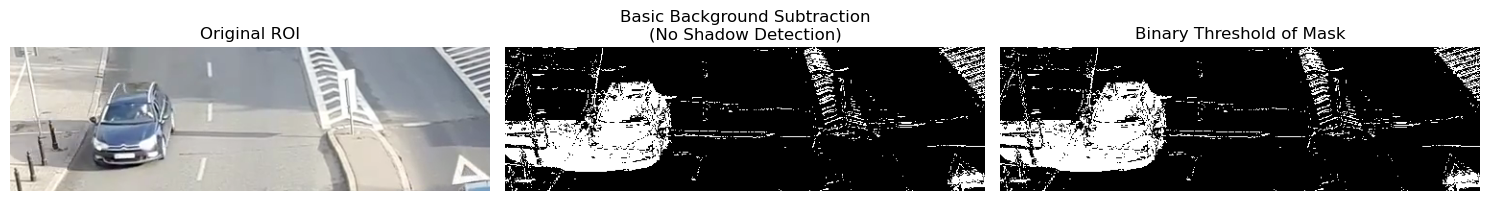

True

In [40]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create a basic background subtractor without shadow detection
basic_bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100, 
    varThreshold=50, 
    detectShadows=False
)

# Process 30 frames to build up the background model
for _ in range(30):
    success, frame = video_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    basic_bg_subtractor.apply(roi_frame, learningRate=0.01)

# Get the next frame to demonstrate basic background subtraction
success, frame = video_cap.read()
if success:
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    
    # Apply basic background subtraction
    basic_fg_mask = basic_bg_subtractor.apply(roi_frame, learningRate=0.01)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
    plt.title("Original ROI")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(basic_fg_mask, cmap='gray')
    plt.title("Basic Background Subtraction\n(No Shadow Detection)")
    plt.axis('off')
    
    # Apply a threshold to show binary result
    _, binary_mask = cv2.threshold(basic_fg_mask, 128, 255, cv2.THRESH_BINARY)
    
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Threshold of Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not read video")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

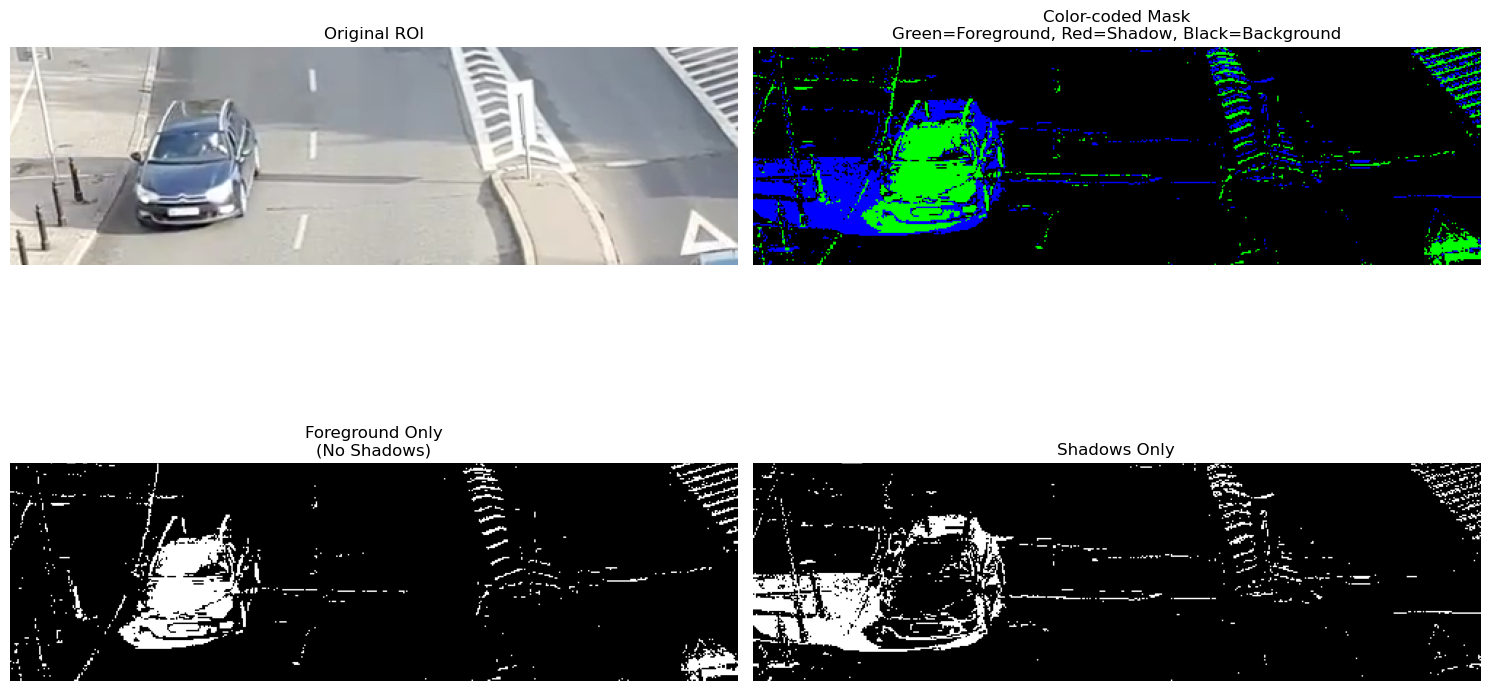

True

In [41]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create a background subtractor with shadow detection
shadow_bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100, 
    varThreshold=50, 
    detectShadows=True
)

# Process 30 frames to build up the background model
for _ in range(30):
    success, frame = video_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    shadow_bg_subtractor.apply(roi_frame, learningRate=0.01)

# Get the next frame to demonstrate shadow detection
success, frame = video_cap.read()
if success:
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    
    # Apply background subtraction with shadow detection
    shadow_fg_mask = shadow_bg_subtractor.apply(roi_frame, learningRate=0.01)
    
    # Create a color version of the mask to highlight different parts
    height, width = shadow_fg_mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Shadows are 127 in the output mask from MOG2
    # Background is 0
    # Foreground is 255
    color_mask[shadow_fg_mask == 0] = [0, 0, 0]      # Black for background
    color_mask[shadow_fg_mask == 127] = [0, 0, 255]  # Red for shadows
    color_mask[shadow_fg_mask == 255] = [0, 255, 0]  # Green for foreground
    
    # Extract just the shadow pixels
    shadow_only = np.zeros_like(shadow_fg_mask)
    shadow_only[shadow_fg_mask == 127] = 255
    
    # Extract just the foreground pixels (no shadows)
    foreground_only = np.zeros_like(shadow_fg_mask)
    foreground_only[shadow_fg_mask == 255] = 255
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
    plt.title("Original ROI")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(color_mask)
    plt.title("Color-coded Mask\nGreen=Foreground, Red=Shadow, Black=Background")
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(foreground_only, cmap='gray')
    plt.title("Foreground Only\n(No Shadows)")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(shadow_only, cmap='gray')
    plt.title("Shadows Only")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not read video")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

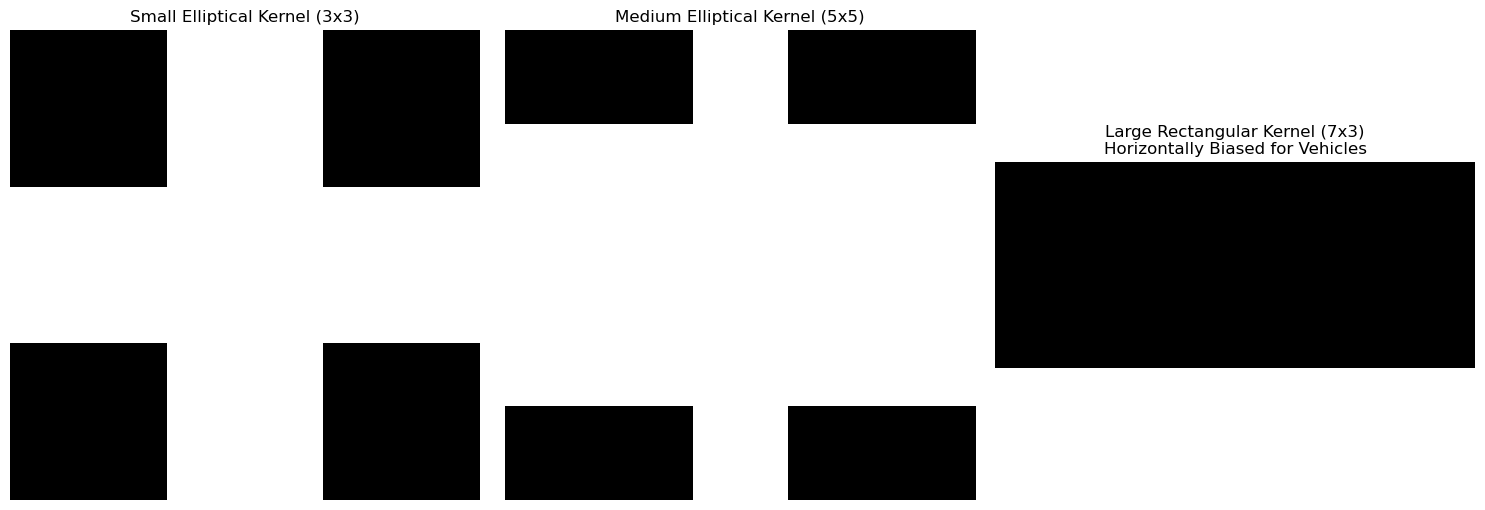

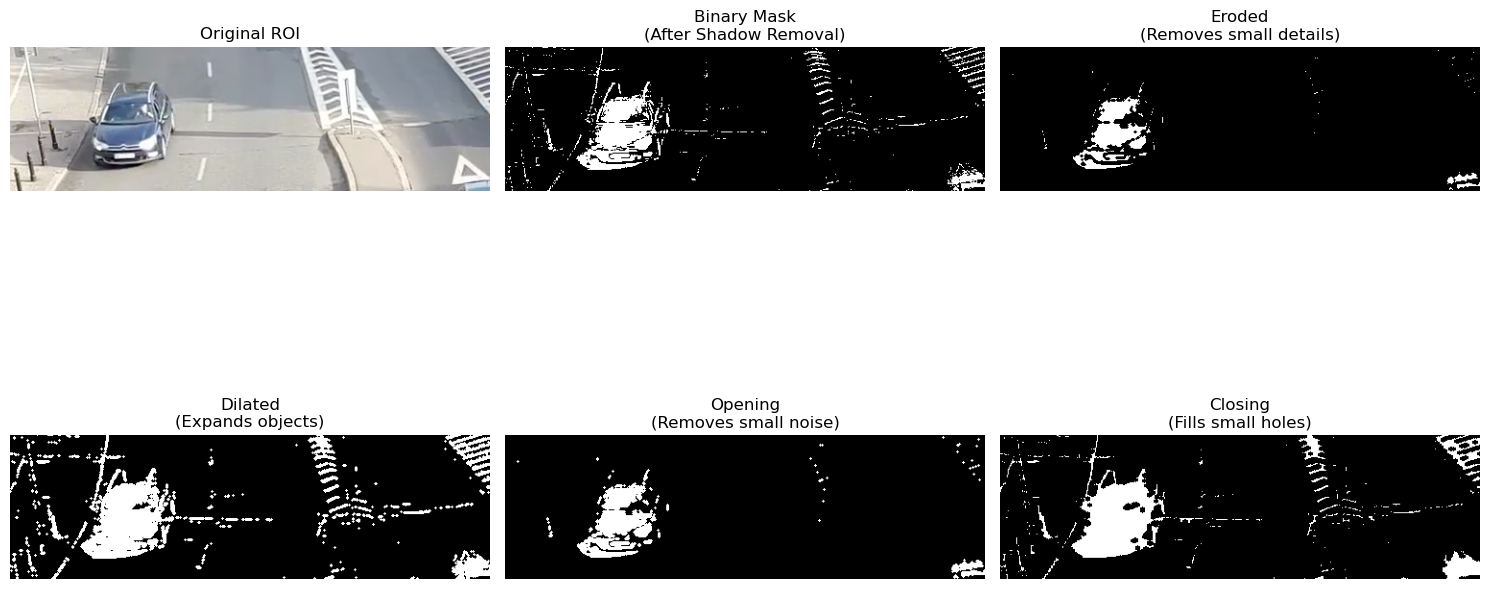

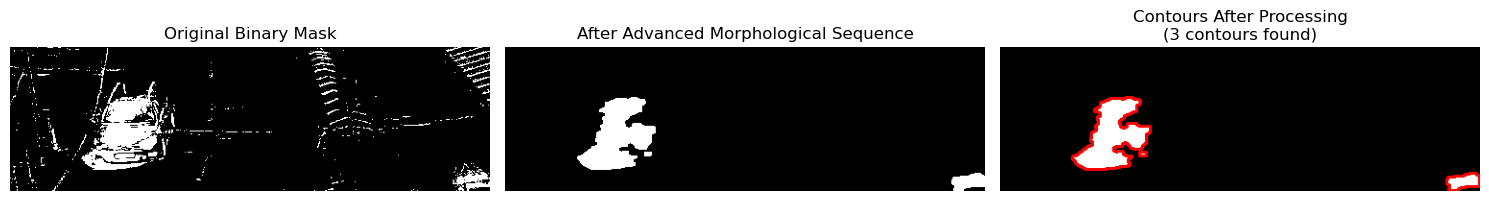

True

In [42]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create a background subtractor
morph_bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100, 
    varThreshold=50, 
    detectShadows=True
)

# Create different kernels for morphological operations
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))  # Horizontally biased

# Visualize the kernels
def visualize_kernel(kernel):
    # Scale up the kernel for better visibility
    scale = 20
    big_kernel = np.zeros((kernel.shape[0] * scale, kernel.shape[1] * scale), dtype=np.uint8)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            if kernel[i, j] == 1:
                big_kernel[i*scale:(i+1)*scale, j*scale:(j+1)*scale] = 255
    return big_kernel

# Show the kernels
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(visualize_kernel(kernel_small), cmap='gray')
plt.title("Small Elliptical Kernel (3x3)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualize_kernel(kernel_medium), cmap='gray')
plt.title("Medium Elliptical Kernel (5x5)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualize_kernel(kernel_large), cmap='gray')
plt.title("Large Rectangular Kernel (7x3)\nHorizontally Biased for Vehicles")
plt.axis('off')

plt.tight_layout()
plt.show()

# Process 30 frames to build up the background model
for _ in range(30):
    success, frame = video_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    morph_bg_subtractor.apply(roi_frame, learningRate=0.01)

# Get the next frame to demonstrate morphological operations
success, frame = video_cap.read()
if success:
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    
    # Apply background subtraction
    fg_mask = morph_bg_subtractor.apply(roi_frame, learningRate=0.01)
    
    # Remove shadows (they are marked as gray (127) in the mask)
    shadow_mask = (fg_mask == 127)
    fg_mask[shadow_mask] = 0
    
    # Convert to binary
    _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    
    # Apply different morphological operations
    # 1. Erosion - Shrinks white regions
    eroded = cv2.erode(binary_mask, kernel_small)
    
    # 2. Dilation - Expands white regions
    dilated = cv2.dilate(binary_mask, kernel_small)
    
    # 3. Opening - Erosion followed by dilation (removes small blobs)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
    
    # 4. Closing - Dilation followed by erosion (fills small holes)
    closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_medium)
    
    # 5. Advanced sequence (what we use in the final code)
    advanced = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)  # Remove noise
    advanced = cv2.morphologyEx(advanced, cv2.MORPH_CLOSE, kernel_medium)   # Fill holes
    advanced = cv2.morphologyEx(advanced, cv2.MORPH_OPEN, kernel_large)     # Separate objects
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
    plt.title("Original ROI")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask\n(After Shadow Removal)")
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(eroded, cmap='gray')
    plt.title("Eroded\n(Removes small details)")
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(dilated, cmap='gray')
    plt.title("Dilated\n(Expands objects)")
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(opening, cmap='gray')
    plt.title("Opening\n(Removes small noise)")
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(closing, cmap='gray')
    plt.title("Closing\n(Fills small holes)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show the advanced sequence with contours
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Original Binary Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(advanced, cmap='gray')
    plt.title("After Advanced Morphological Sequence")
    plt.axis('off')
    
    # Find contours in original vs advanced
    original_cnts = cv2.findContours(binary_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    original_cnts = imutils.grab_contours(original_cnts)
    
    advanced_cnts = cv2.findContours(advanced.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    advanced_cnts = imutils.grab_contours(advanced_cnts)
    
    # Draw contours on ROI copies
    original_contour_img = cv2.cvtColor(binary_mask.copy(), cv2.COLOR_GRAY2BGR)
    advanced_contour_img = cv2.cvtColor(advanced.copy(), cv2.COLOR_GRAY2BGR)
    
    cv2.drawContours(original_contour_img, original_cnts, -1, (0, 0, 255), 2)
    cv2.drawContours(advanced_contour_img, advanced_cnts, -1, (0, 0, 255), 2)
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(advanced_contour_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours After Processing\n({len(advanced_cnts)} contours found)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not read video")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

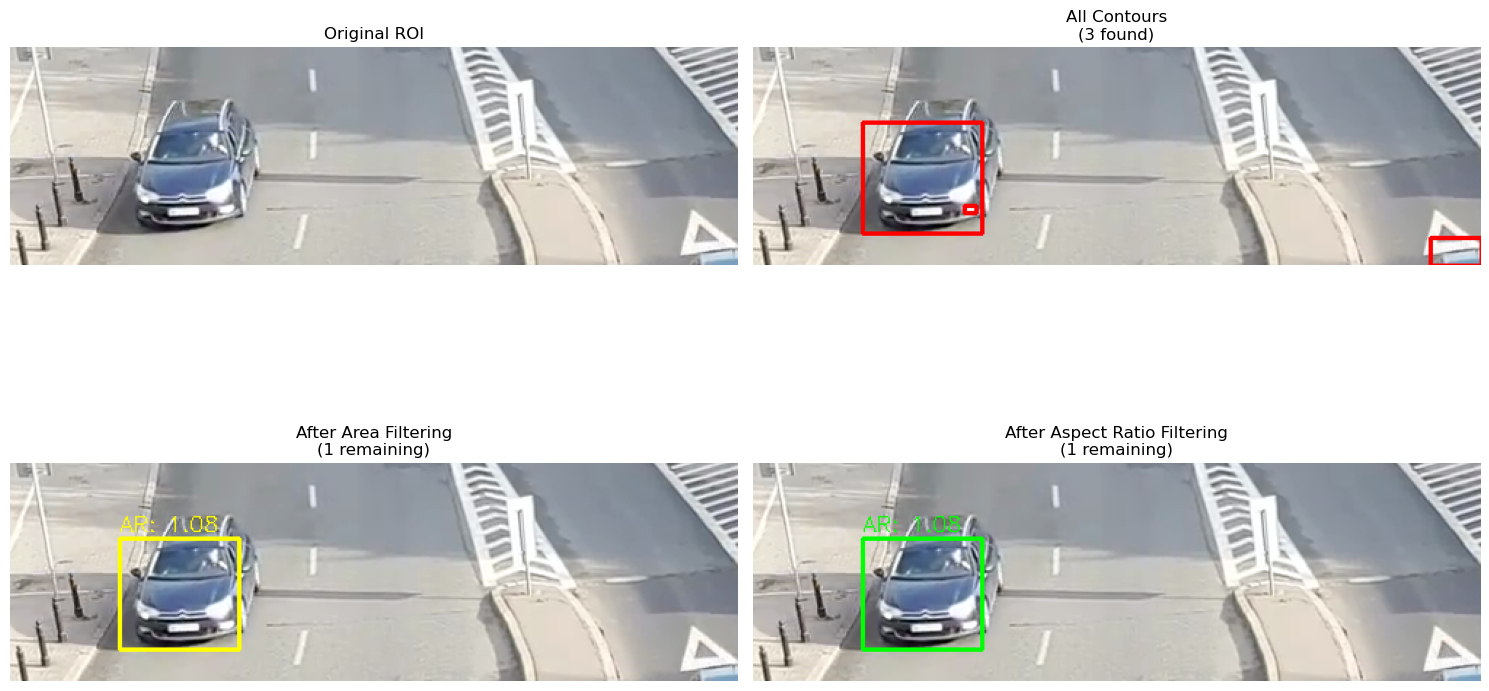

True

In [43]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create a background subtractor
aspect_bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100, 
    varThreshold=50, 
    detectShadows=True
)

# Process 30 frames to build up the background model
for _ in range(30):
    success, frame = video_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    aspect_bg_subtractor.apply(roi_frame, learningRate=0.01)

# Create the kernels and MIN_AREA threshold
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
MIN_AREA = 700

# Get the next frame to demonstrate aspect ratio filtering
success, frame = video_cap.read()
if success:
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
    
    # Apply background subtraction
    fg_mask = aspect_bg_subtractor.apply(roi_frame, learningRate=0.01)
    
    # Remove shadows
    shadow_mask = (fg_mask == 127)
    fg_mask[shadow_mask] = 0
    
    # Convert to binary
    _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel_medium)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel_large)
    
    # Find contours
    cnts = cv2.findContours(processed_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Create images to draw on
    all_contours_img = roi_frame.copy()
    area_filtered_img = roi_frame.copy()
    aspect_filtered_img = roi_frame.copy()
    
    # Statistics
    total_contours = len(cnts)
    area_filtered_count = 0
    aspect_filtered_count = 0
    
    # Process contours with different filtering
    for c in cnts:
        # Get contour properties
        area = cv2.contourArea(c)
        (x, y, w, h) = cv2.boundingRect(c)
        aspect_ratio = float(w) / h if h > 0 else 0
        
        # Draw all contours in red
        cv2.rectangle(all_contours_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        
        # Check area filter
        if area < MIN_AREA:
            continue  # Skip small contours
        
        # Draw area-filtered contours in yellow
        cv2.rectangle(area_filtered_img, (x, y), (x+w, y+h), (0, 255, 255), 2)
        cv2.putText(area_filtered_img, f"AR: {aspect_ratio:.2f}", (x, y-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        area_filtered_count += 1
        
        # Check aspect ratio filter
        if aspect_ratio < 0.5 or aspect_ratio > 3.0:
            continue  # Skip unusual aspect ratios
        
        # Draw fully filtered contours in green
        cv2.rectangle(aspect_filtered_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(aspect_filtered_img, f"AR: {aspect_ratio:.2f}", (x, y-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        aspect_filtered_count += 1
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
    plt.title("Original ROI")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(all_contours_img, cv2.COLOR_BGR2RGB))
    plt.title(f"All Contours\n({total_contours} found)")
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(area_filtered_img, cv2.COLOR_BGR2RGB))
    plt.title(f"After Area Filtering\n({area_filtered_count} remaining)")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(aspect_filtered_img, cv2.COLOR_BGR2RGB))
    plt.title(f"After Aspect Ratio Filtering\n({aspect_filtered_count} remaining)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not read video")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

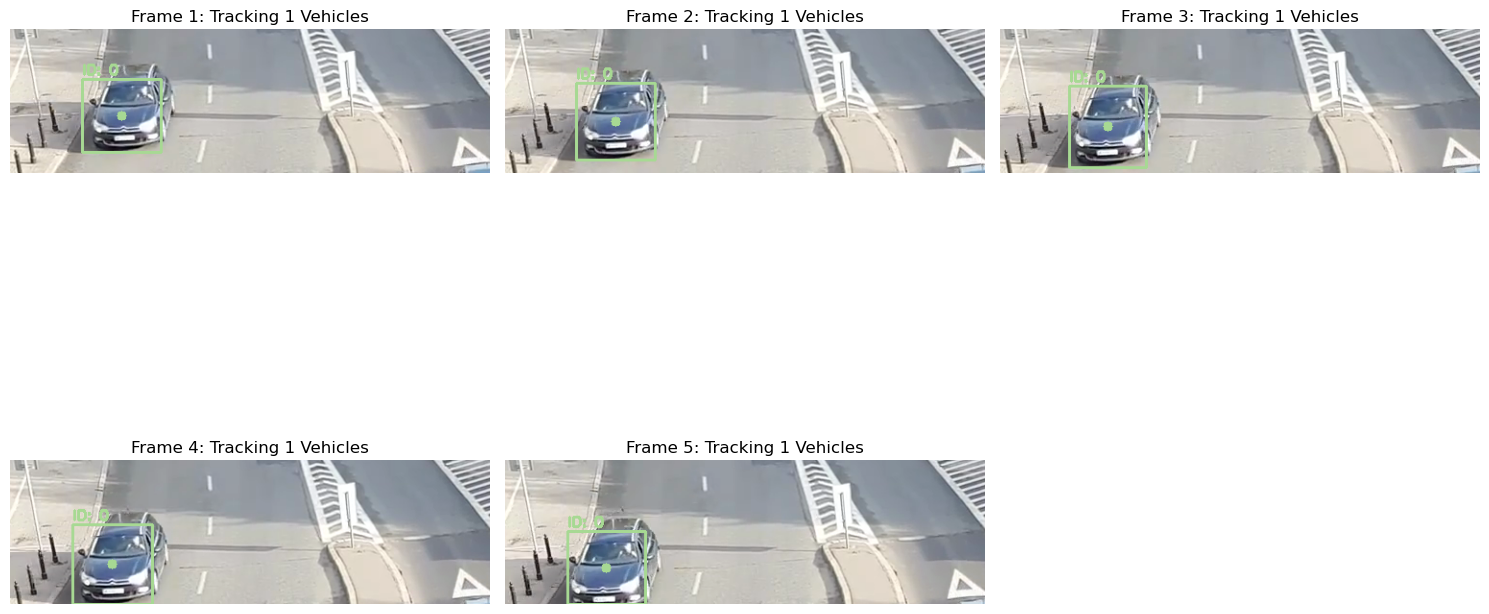

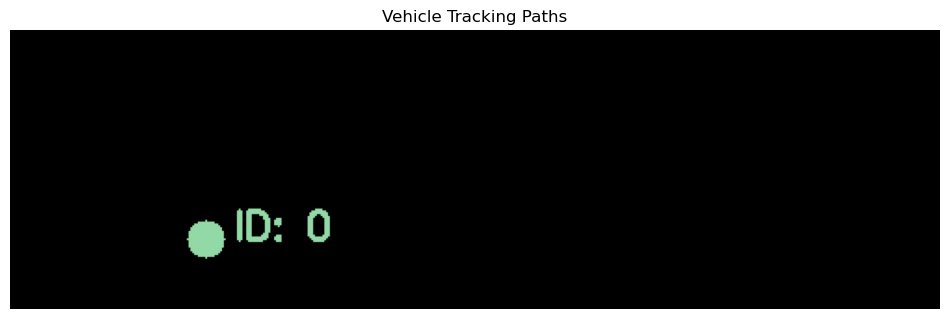

True

In [44]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create a background subtractor
tracking_bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100, 
    varThreshold=50, 
    detectShadows=True
)

# Create morphological kernels
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))

# Vehicle tracking parameters
MIN_AREA = 700
tracked_vehicles = {}
next_vehicle_id = 0
tracking_frames = 5  # Number of frames to show tracking

# Process some frames to build up the background model
for _ in range(30):
    success, frame = video_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    tracking_bg_subtractor.apply(roi_frame, learningRate=0.01)

# Prepare to store frames for visualization
tracking_frames_list = []
for frame_idx in range(tracking_frames):
    success, frame = video_cap.read()
    if not success:
        print(f"Could only read {frame_idx} frames")
        break
        
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
    
    # Process the frame
    fg_mask = tracking_bg_subtractor.apply(roi_frame, learningRate=0.01)
    
    # Remove shadows
    shadow_mask = (fg_mask == 127)
    fg_mask[shadow_mask] = 0
    
    # Convert to binary
    _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel_medium)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel_large)
    
    # Find contours
    cnts = cv2.findContours(processed_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Create tracking image
    tracking_img = roi_frame.copy()
    current_active_vehicles = set()
    
    # Process contours
    for c in cnts:
        # Filter contours by area
        if cv2.contourArea(c) < MIN_AREA:
            continue
            
        # Get the bounding box
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Filter by aspect ratio
        aspect_ratio = float(w) / h if h > 0 else 0
        if aspect_ratio < 0.5 or aspect_ratio > 3.0:
            continue
        
        # Calculate center point for tracking
        center_x = x + w/2
        center_y = y + h/2
        
        # Check if this matches a vehicle we're already tracking
        matched = False
        for v_id, vehicle_data in list(tracked_vehicles.items()):
            prev_x, prev_y, prev_frame = vehicle_data
            
            # Calculate distance between centers
            distance = np.sqrt((center_x - prev_x)**2 + (center_y - prev_y)**2)
            
            # If close enough, consider it the same vehicle
            if distance < 50:  # Adjust threshold as needed
                tracked_vehicles[v_id] = (center_x, center_y, frame_idx)
                current_active_vehicles.add(v_id)
                matched = True
                break
        
        # If no match found, create new vehicle ID
        if not matched:
            tracked_vehicles[next_vehicle_id] = (center_x, center_y, frame_idx)
            current_active_vehicles.add(next_vehicle_id)
            next_vehicle_id += 1
        
        # Draw rectangles with different colors based on tracking ID
        for v_id in current_active_vehicles:
            # Generate consistent color for this vehicle ID
            np.random.seed(v_id * 100)  # Ensure same color for same ID
            color = (
                int(np.random.randint(100, 255)),
                int(np.random.randint(100, 255)),
                int(np.random.randint(100, 255))
            )
            
            v_x, v_y, _ = tracked_vehicles[v_id]
            cv2.circle(tracking_img, (int(v_x), int(v_y)), 5, color, -1)
            
            # Only draw rectangle if it's the current vehicle
            if v_x >= x and v_x <= x+w and v_y >= y and v_y <= y+h:
                cv2.rectangle(tracking_img, (x, y), (x+w, y+h), color, 2)
                cv2.putText(tracking_img, f"ID: {v_id}", (x, y-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add frame to our list
    tracking_frames_list.append(tracking_img)

# Display the tracking sequence
if tracking_frames_list:
    plt.figure(figsize=(15, 10))
    
    for i, img in enumerate(tracking_frames_list):
        plt.subplot(2, 3, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}: Tracking {len(tracked_vehicles)} Vehicles")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show vehicle paths
    path_img = np.zeros((ROI_HEIGHT, ROI_WIDTH, 3), dtype=np.uint8)
    
    # Draw paths of each tracked vehicle
    for v_id, (latest_x, latest_y, latest_frame) in tracked_vehicles.items():
        # Generate consistent color for this vehicle
        np.random.seed(v_id * 100)
        color = (
            int(np.random.randint(100, 255)),
            int(np.random.randint(100, 255)),
            int(np.random.randint(100, 255))
        )
        
        cv2.circle(path_img, (int(latest_x), int(latest_y)), 10, color, -1)
        cv2.putText(path_img, f"ID: {v_id}", (int(latest_x)+15, int(latest_y)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(path_img)
    plt.title("Vehicle Tracking Paths")
    plt.axis('off')
    plt.show()
else:
    print("Not enough frames to show tracking")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

In [9]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Run the complete detection system for a sequence of frames
def run_complete_vehicle_detection(frames_to_process=20):
    # Parameters
    THRESHOLD_VALUE = 25
    MIN_AREA = 700
    HISTORY_FRAMES = 100
    LEARNING_RATE = 0.005
    
    # Setup background subtractor
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=HISTORY_FRAMES, 
        varThreshold=50, 
        detectShadows=True
    )
    
    # Create kernels for morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    
    # Skip some initial frames to let background model stabilize
    for _ in range(30):
        success, frame = video_cap.read()
        if not success:
            break
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
        bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
    
    # Vehicle tracking and counting
    tracked_vehicles = {}
    next_vehicle_id = 0
    vehicle_count = 0
    
    # Store frames and processing steps for visualization
    original_frames = []
    processed_masks = []
    result_frames = []
    
    for frame_idx in range(frames_to_process):
        success, frame = video_cap.read()
        if not success:
            print(f"Could only process {frame_idx} frames")
            break
            
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
        original_frames.append(roi_frame.copy())
        
        # Draw ROI on main frame
        cv2.rectangle(frame, (ROI_X, ROI_Y), (ROI_X + ROI_WIDTH, ROI_Y + ROI_HEIGHT), (0, 0, 255), 2)
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
        
        # Remove shadows
        shadow_mask = (fg_mask == 127)
        fg_mask[shadow_mask] = 0
        
        # Convert to binary
        _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        
        # Apply morphological operations
        morph_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_CLOSE, kernel_medium)
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_OPEN, kernel_large)
        
        processed_masks.append(morph_mask.copy())
        
        # Find contours
        cnts = cv2.findContours(morph_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        current_active_vehicles = set()
        
        # Process contours
        for c in cnts:
            # Filter contours by area
            contour_area = cv2.contourArea(c)
            if contour_area < MIN_AREA:
                continue
                
            # Get bounding box
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Filter by aspect ratio
            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 3.0:
                continue
                
            # Calculate center point for tracking
            center_x = x + w/2
            center_y = y + h/2
            
            # Check if this matches a vehicle we're already tracking
            matched = False
            for v_id, vehicle_data in list(tracked_vehicles.items()):
                prev_x, prev_y, last_seen, counted = vehicle_data
                # Calculate distance between centers
                distance = np.sqrt((center_x - prev_x)**2 + (center_y - prev_y)**2)
                
                # If close enough, consider it the same vehicle
                if distance < 50:
                    tracked_vehicles[v_id] = (center_x, center_y, frame_idx, counted)
                    current_active_vehicles.add(v_id)
                    matched = True
                    break
            
            # If no match found, create new vehicle ID
            if not matched:
                # Only consider new if it's near the edge (likely entering)
                near_edge = (x < 20 or x + w > ROI_WIDTH - 20 or 
                             y < 20 or y + h > ROI_HEIGHT - 20)
                tracked_vehicles[next_vehicle_id] = (center_x, center_y, frame_idx, False)
                current_active_vehicles.add(next_vehicle_id)
                next_vehicle_id += 1
            
            # Generate consistent color for this contour's ID
            if matched:
                color = (0, 255, 0)  # Green for matched vehicles
            else:
                color = (255, 0, 0)  # Blue for new vehicles
            
            # Draw the rectangle
            cv2.rectangle(roi_frame, (x, y), (x+w, y+h), color, 2)
            
            # Add contour area and aspect ratio
            cv2.putText(roi_frame, f"Area: {contour_area:.0f}", (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            cv2.putText(roi_frame, f"AR: {aspect_ratio:.2f}", (x, y-20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
        
        # Count vehicles that have moved through the middle of ROI
        for v_id in list(tracked_vehicles.keys()):
            if v_id in current_active_vehicles:
                # Vehicle is still active
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                
                # If vehicle is in middle third and hasn't been counted yet
                if ROI_HEIGHT/3 < center_y < 2*ROI_HEIGHT/3 and not counted:
                    tracked_vehicles[v_id] = (center_x, center_y, last_seen, True)
                    vehicle_count += 1
                    
                # Draw ID on frame
                cv2.putText(roi_frame, f"ID: {v_id}", (int(center_x), int(center_y)),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
            else:
                # Vehicle is no longer visible
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                if frame_idx - last_seen > 2:  # Remove after not seeing for 2 frames
                    del tracked_vehicles[v_id]
        
        # Draw counting line
        cv2.line(roi_frame, (0, int(ROI_HEIGHT/3)), (ROI_WIDTH, int(ROI_HEIGHT/3)), (255, 0, 0), 1)
        cv2.line(roi_frame, (0, int(2*ROI_HEIGHT/3)), (ROI_WIDTH, int(2*ROI_HEIGHT/3)), (255, 0, 0), 1)
        
        # Add vehicle count to frame
        cv2.putText(frame, f"Vehicle Count: {vehicle_count}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        # Store the resulting frame
        result_frames.append(roi_frame.copy())
    
    return original_frames, processed_masks, result_frames, vehicle_count

# Run the detection system
original_frames, processed_masks, result_frames, final_count = run_complete_vehicle_detection(10)

# Display a selection of the processing sequence
if original_frames:
    num_frames = len(original_frames)
    frames_to_show = min(5, num_frames)
    
    plt.figure(figsize=(15, 10))
    
    for i in range(frames_to_show):
        # Pick frames spaced throughout the sequence
        idx = i * num_frames // frames_to_show
        
        # Original ROI
        plt.subplot(3, frames_to_show, i+1)
        plt.imshow(cv2.cvtColor(original_frames[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {idx+1}: Original")
        plt.axis('off')
        
        # Processed mask
        plt.subplot(3, frames_to_show, i+1+frames_to_show)
        plt.imshow(processed_masks[idx], cmap='gray')
        plt.title(f"Frame {idx+1}: Processed Mask")
        plt.axis('off')
        
        # Result with detections
        plt.subplot(3, frames_to_show, i+1+2*frames_to_show)
        plt.imshow(cv2.cvtColor(result_frames[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {idx+1}: Detection Result")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Complete Vehicle Detection Process (Final Count: {final_count})", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No frames were processed")

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

Could only process 0 frames
No frames were processed


False

In [ ]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# This cell lets you experiment with different parameters and see their effects
from ipywidgets import interact, IntSlider, FloatSlider, Output, VBox, HBox
import IPython.display as display

# Create output area for displaying results
out = Output()

# Define the function that will process a frame with given parameters
@interact(
    threshold=IntSlider(min=10, max=100, step=5, value=25, description='Threshold:'),
    min_area=IntSlider(min=100, max=2000, step=100, value=700, description='Min Area:'),
    learning_rate=FloatSlider(min=0.001, max=0.05, step=0.001, value=0.005, description='Learning Rate:'),
    erosion=IntSlider(min=0, max=5, step=1, value=1, description='Erosion:'),
    dilation=IntSlider(min=0, max=5, step=1, value=1, description='Dilation:')
)
def tune_parameters(threshold, min_area, learning_rate, erosion, dilation):
    # Clear previous output
    out.clear_output()
    
    with out:
        # Reset video to a consistent position
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, 100)  # Skip first 100 frames
        
        # Setup background subtractor
        bg_subtractor = cv2.createBackgroundSubtractorMOG2(
            history=100, 
            varThreshold=50, 
            detectShadows=True
        )
        
        # Create kernels
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        
        # Skip some frames and build background model
        for _ in range(30):
            success, frame = video_cap.read()
            if not success:
                print("Failed to read video")
                return
                
            frame = cv2.resize(frame, (1920, 1080))
            roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
            bg_subtractor.apply(roi_frame, learningRate=learning_rate)
        
        # Get the next frame for demonstration
        success, frame = video_cap.read()
        if not success:
            print("Failed to read frame")
            return
            
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(roi_frame, learningRate=learning_rate)
        
        # Remove shadows
        shadow_mask = (fg_mask == 127)
        fg_mask[shadow_mask] = 0
        
        # Apply threshold
        _, binary_mask = cv2.threshold(fg_mask, threshold, 255, cv2.THRESH_BINARY)
        
        # Apply morphological operations
        morph_mask = binary_mask.copy()
        
        # Apply erosion if specified
        if erosion > 0:
            morph_mask = cv2.erode(morph_mask, kernel, iterations=erosion)
            
        # Apply dilation if specified
        if dilation > 0:
            morph_mask = cv2.dilate(morph_mask, kernel, iterations=dilation)
        
        # Find contours
        cnts = cv2.findContours(morph_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        # Filter and draw contours
        detection_img = roi_frame.copy()
        valid_contours = 0
        
        for c in cnts:
            # Filter by area
            area = cv2.contourArea(c)
            if area < min_area:
                continue
                
            # Get bounding box
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Calculate aspect ratio
            aspect_ratio = float(w) / h if h > 0 else 0
            
            # Determine color based on aspect ratio
            if 0.5 <= aspect_ratio <= 3.0:
                color = (0, 255, 0)  # Green for good aspect ratio
                valid_contours += 1
            else:
                color = (0, 0, 255)  # Red for bad aspect ratio
            
            # Draw rectangle
            cv2.rectangle(detection_img, (x, y), (x+w, y+h), color, 2)
            
            # Add area and aspect ratio
            cv2.putText(detection_img, f"A: {area:.0f}", (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            cv2.putText(detection_img, f"AR: {aspect_ratio:.2f}", (x, y-20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB))
        plt.title("Original ROI")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(morph_mask, cmap='gray')
        plt.title(f"Processed Mask\nThreshold={threshold}, Erosion={erosion}, Dilation={dilation}")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detection Result\nMin Area={min_area}, Valid Objects={valid_contours}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Display the interactive widget
VBox([
    HBox([out])
])

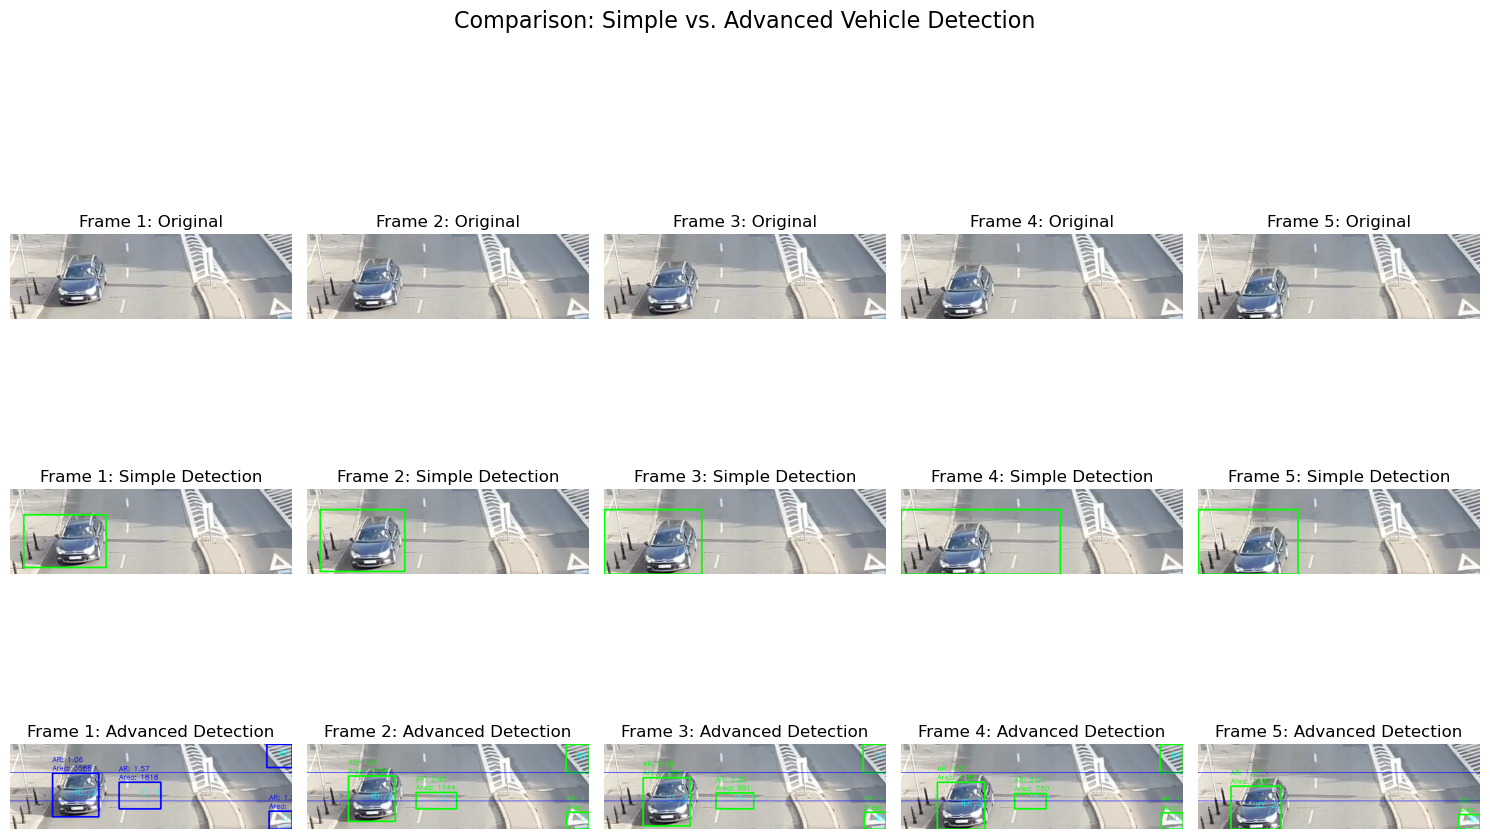

In [6]:
# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Function to run a simple detection approach
def run_simple_detection(frames_to_process=5):
    # Skip initial frames
    for _ in range(30):
        success, frame = video_cap.read()
        if not success:
            break
    
    # Store the static background
    success, frame = video_cap.read()
    if not success:
        print("Could not read frame")
        return None, None, None
        
    frame = cv2.resize(frame, (1920, 1080))
    roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
    static_background = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)
    
    # Store frames and results
    original_frames = []
    simple_results = []
    
    for i in range(frames_to_process):
        success, frame = video_cap.read()
        if not success:
            break
            
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
        original_frames.append(roi_frame.copy())
        
        # Convert to grayscale
        gray_roi = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)
        
        # Simple frame differencing
        diff = cv2.absdiff(static_background, gray_roi)
        
        # Threshold
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
        
        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        # Draw contours
        simple_result = roi_frame.copy()
        
        for c in cnts:
            if cv2.contourArea(c) < 700:
                continue
                
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(simple_result, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        simple_results.append(simple_result)
    
    return original_frames, simple_results

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Run advanced detection for comparison
advanced_originals, advanced_masks, advanced_results, _ = run_complete_vehicle_detection(5)

# Reset video position
video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Run simple detection for comparison
simple_originals, simple_results = run_simple_detection(5)

# Compare the results
if advanced_results and simple_results:
    num_frames = min(len(advanced_results), len(simple_results))
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_frames):
        # Original frame
        plt.subplot(3, num_frames, i+1)
        plt.imshow(cv2.cvtColor(advanced_originals[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}: Original")
        plt.axis('off')
        
        # Simple detection result
        plt.subplot(3, num_frames, i+1+num_frames)
        plt.imshow(cv2.cvtColor(simple_results[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}: Simple Detection")
        plt.axis('off')
        
        # Advanced detection result
        plt.subplot(3, num_frames, i+1+2*num_frames)
        plt.imshow(cv2.cvtColor(advanced_results[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}: Advanced Detection")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Comparison: Simple vs. Advanced Vehicle Detection", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("Error processing frames for comparison")

# Close the video
video_cap.release()

# Working Examples

In [10]:
import cv2
import imutils
import time
import numpy as np

video_path = 'test_cars.mp4'
video_cap = cv2.VideoCapture(video_path)

# Motion detection parameters - easily adjustable
THRESHOLD_VALUE = 25       # Lower = more sensitive, Higher = less sensitive
MIN_AREA = 700             # Minimum contour area to consider
BLUR_SIZE = (7, 7)         # Blur kernel size for noise reduction
ROI_X, ROI_Y = 400, 200    # ROI position
ROI_WIDTH, ROI_HEIGHT = 500, 150  # ROI dimensions
HISTORY_FRAMES = 100       # For background subtractor - more history for stability
LEARNING_RATE = 0.005      # How quickly background model adapts to changes (smaller = slower)

try:
    # Read first frame to get dimensions
    success, frame = video_cap.read()
    if not success:
        print("Failed to read from video source")
        exit()
        
    frame = cv2.resize(frame, (1920, 1080))
    
    # Create a background subtractor with shadow detection
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=HISTORY_FRAMES, 
        varThreshold=50, 
        detectShadows=True  # Enable shadow detection
    )
    
    # Create kernels for morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))  # Horizontally biased for vehicles
    
    # Skip some initial frames to let background model stabilize
    for _ in range(30):  # Process more frames for better initialization
        success, frame = video_cap.read()
        if not success:
            break
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
        bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
    
    # Counter for vehicle detection
    vehicle_count = 0
    last_detection_time = time.time()
    
    # For vehicle tracking
    tracked_vehicles = {}
    next_vehicle_id = 0
    
    while True:
        success, frame = video_cap.read()
        if not success:
            print("End of video or failed to read frame")
            break

        frame = cv2.resize(frame, (1920, 1080))
        
        # Extract the ROI for processing
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
        
        # Remove shadows (they are marked as gray (127) in the mask)
        shadow_mask = (fg_mask == 127)
        fg_mask[shadow_mask] = 0  # Set shadows to black (background)
        
        # Convert to binary mask (foreground only)
        _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        
        # Apply noise reduction with Gaussian blur
        blurred_mask = cv2.GaussianBlur(binary_mask, BLUR_SIZE, 0)
        _, binary_mask = cv2.threshold(blurred_mask, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
        
        # Apply advanced morphological operations
        # 1. Opening to remove small noise (erosion followed by dilation)
        morph_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
        
        # 2. Closing to fill small holes inside detected objects
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_CLOSE, kernel_medium)
        
        # 3. Another opening with larger kernel to better separate objects
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_OPEN, kernel_large)
        
        # Find contours in the processed mask
        cnts = cv2.findContours(morph_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        motion_detected = False
        current_time = time.time()
        current_active_vehicles = set()
        
        # Draw the ROI rectangle on the main frame
        cv2.rectangle(frame, (ROI_X, ROI_Y), (ROI_X + ROI_WIDTH, ROI_Y + ROI_HEIGHT), (0, 0, 255), 2)

        # Process contours within the ROI
        for c in cnts:
            # Filter contours by area
            contour_area = cv2.contourArea(c)
            if contour_area < MIN_AREA:
                continue
                
            # Get bounding box
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Additional filtering - aspect ratio check for vehicles
            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 3.0:
                continue  # Skip objects with unusual aspect ratios
                
            # Calculate center point for tracking
            center_x = x + w/2
            center_y = y + h/2
            
            # Check if this matches a vehicle we're already tracking
            matched = False
            for v_id, vehicle_data in list(tracked_vehicles.items()):
                prev_x, prev_y, last_seen, counted = vehicle_data
                # Calculate distance between centers
                distance = np.sqrt((center_x - prev_x)**2 + (center_y - prev_y)**2)
                
                # If close enough, consider it the same vehicle
                if distance < 50:  # Adjust threshold as needed
                    # Update tracking information
                    tracked_vehicles[v_id] = (center_x, center_y, current_time, counted)
                    current_active_vehicles.add(v_id)
                    matched = True
                    break
            
            # If no match found, create new vehicle ID
            if not matched:
                # Only count as new if it's near the edge (likely entering)
                near_edge = (x < 20 or x + w > ROI_WIDTH - 20)
                tracked_vehicles[next_vehicle_id] = (center_x, center_y, current_time, False)
                current_active_vehicles.add(next_vehicle_id)
                next_vehicle_id += 1
            
            # Draw bounding box
            cv2.rectangle(roi_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Add contour area as text
            cv2.putText(roi_frame, f"Area: {contour_area:.0f}", (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            motion_detected = True
        
        # Count vehicles that have moved significantly through the ROI
        for v_id in list(tracked_vehicles.keys()):
            if v_id in current_active_vehicles:
                # Vehicle is still active
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                
                # If vehicle has moved through the middle of ROI and hasn't been counted yet
                if center_y > ROI_HEIGHT/3 and center_y < 2*ROI_HEIGHT/3 and not counted:
                    tracked_vehicles[v_id] = (center_x, center_y, last_seen, True)
                    vehicle_count += 1
            else:
                # Vehicle is no longer visible
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                if current_time - last_seen > 0.5:  # Remove after 0.5 seconds of not seeing
                    del tracked_vehicles[v_id]
        
        # Display detection status
        if motion_detected:
            cv2.putText(frame, "Motion DETECTED", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
        
        # Show vehicle count
        cv2.putText(frame, f"Vehicle Count: {vehicle_count}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 3)
        
        # Show frames
        cv2.imshow("Motion Detection", frame)
        cv2.imshow("ROI Threshold", morph_mask)  # Show processed mask for debugging
        
        # Optionally show shadow mask for debugging
        cv2.imshow("Shadow Mask", shadow_mask.astype(np.uint8) * 255)
        
        # Key handling
        key = cv2.waitKey(100) & 0xFF
        if key == 27 or key == ord('q'):  # ESC or 'q' key
            print("User requested exit")
            break
            
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Cleanup
    print("Cleaning up resources")
    video_cap.release()
    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)

User requested exit
Cleaning up resources


In [ ]:
import cv2
import imutils
import time
import numpy as np

video_path = 'vid.mp4'
video_cap = cv2.VideoCapture(video_path)

# Motion detection parameters - easily adjustable
THRESHOLD_VALUE = 25       # Lower = more sensitive, Higher = less sensitive
MIN_AREA = 700             # Minimum contour area to consider
BLUR_SIZE = (7, 7)         # Blur kernel size for noise reduction
ROI_X, ROI_Y = 450, 300    # ROI position
ROI_WIDTH, ROI_HEIGHT = 850, 200  # ROI dimensions
HISTORY_FRAMES = 100       # For background subtractor - more history for stability
LEARNING_RATE = 0.005      # How quickly background model adapts to changes (smaller = slower)

try:
    # Read first frame to get dimensions
    success, frame = video_cap.read()
    if not success:
        print("Failed to read from video source")
        exit()
        
    frame = cv2.resize(frame, (1920, 1080))
    
    # Create a background subtractor with shadow detection
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=HISTORY_FRAMES, 
        varThreshold=50, 
        detectShadows=True  # Enable shadow detection
    )
    
    # Create kernels for morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))  # Horizontally biased for vehicles
    
    # Skip some initial frames to let background model stabilize
    for _ in range(30):  # Process more frames for better initialization
        success, frame = video_cap.read()
        if not success:
            break
        frame = cv2.resize(frame, (1920, 1080))
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH]
        bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
    
    # Counter for vehicle detection
    vehicle_count = 0
    last_detection_time = time.time()
    
    # For vehicle tracking
    tracked_vehicles = {}
    next_vehicle_id = 0
    
    while True:
        success, frame = video_cap.read()
        if not success:
            print("End of video or failed to read frame")
            break

        frame = cv2.resize(frame, (1920, 1080))
        
        # Extract the ROI for processing
        roi_frame = frame[ROI_Y:ROI_Y+ROI_HEIGHT, ROI_X:ROI_X+ROI_WIDTH].copy()
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(roi_frame, learningRate=LEARNING_RATE)
        
        # Remove shadows (they are marked as gray (127) in the mask)
        shadow_mask = (fg_mask == 127)
        fg_mask[shadow_mask] = 0  # Set shadows to black (background)
        
        # Convert to binary mask (foreground only)
        _, binary_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
        
        # Apply noise reduction with Gaussian blur
        blurred_mask = cv2.GaussianBlur(binary_mask, BLUR_SIZE, 0)
        _, binary_mask = cv2.threshold(blurred_mask, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
        
        # Apply advanced morphological operations
        # 1. Opening to remove small noise (erosion followed by dilation)
        morph_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)
        
        # 2. Closing to fill small holes inside detected objects
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_CLOSE, kernel_medium)
        
        # 3. Another opening with larger kernel to better separate objects
        morph_mask = cv2.morphologyEx(morph_mask, cv2.MORPH_OPEN, kernel_large)
        
        # Find contours in the processed mask
        cnts = cv2.findContours(morph_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        motion_detected = False
        current_time = time.time()
        current_active_vehicles = set()
        
        # Draw the ROI rectangle on the main frame
        cv2.rectangle(frame, (ROI_X, ROI_Y), (ROI_X + ROI_WIDTH, ROI_Y + ROI_HEIGHT), (0, 0, 255), 2)

        # Process contours within the ROI
        for c in cnts:
            # Filter contours by area
            contour_area = cv2.contourArea(c)
            if contour_area < MIN_AREA:
                continue
                
            # Get bounding box
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Additional filtering - aspect ratio check for vehicles
            aspect_ratio = float(w) / h
            if aspect_ratio < 0.5 or aspect_ratio > 3.0:
                continue  # Skip objects with unusual aspect ratios
                
            # Calculate center point for tracking
            center_x = x + w/2
            center_y = y + h/2
            
            # Check if this matches a vehicle we're already tracking
            matched = False
            for v_id, vehicle_data in list(tracked_vehicles.items()):
                prev_x, prev_y, last_seen, counted = vehicle_data
                # Calculate distance between centers
                distance = np.sqrt((center_x - prev_x)**2 + (center_y - prev_y)**2)
                
                # If close enough, consider it the same vehicle
                if distance < 50:  # Adjust threshold as needed
                    # Update tracking information
                    tracked_vehicles[v_id] = (center_x, center_y, current_time, counted)
                    current_active_vehicles.add(v_id)
                    matched = True
                    break
            
            # If no match found, create new vehicle ID
            if not matched:
                # Only count as new if it's near the edge (likely entering)
                near_edge = (x < 20 or x + w > ROI_WIDTH - 20)
                tracked_vehicles[next_vehicle_id] = (center_x, center_y, current_time, False)
                current_active_vehicles.add(next_vehicle_id)
                next_vehicle_id += 1
            
            # Draw bounding box
            cv2.rectangle(roi_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Add contour area as text
            cv2.putText(roi_frame, f"Area: {contour_area:.0f}", (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            motion_detected = True
        
        # Count vehicles that have moved significantly through the ROI
        for v_id in list(tracked_vehicles.keys()):
            if v_id in current_active_vehicles:
                # Vehicle is still active
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                
                # If vehicle has moved through the middle of ROI and hasn't been counted yet
                if center_y > ROI_HEIGHT/3 and center_y < 2*ROI_HEIGHT/3 and not counted:
                    tracked_vehicles[v_id] = (center_x, center_y, last_seen, True)
                    vehicle_count += 1
            else:
                # Vehicle is no longer visible
                center_x, center_y, last_seen, counted = tracked_vehicles[v_id]
                if current_time - last_seen > 0.5:  # Remove after 0.5 seconds of not seeing
                    del tracked_vehicles[v_id]
        
        # Display detection status
        if motion_detected:
            cv2.putText(frame, "Motion DETECTED", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
        
        # Show vehicle count
        cv2.putText(frame, f"Vehicle Count: {vehicle_count}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 3)
        
        # Show frames
        cv2.imshow("Motion Detection", frame)
        cv2.imshow("ROI Threshold", morph_mask)  # Show processed mask for debugging
        
        # Optionally show shadow mask for debugging
        cv2.imshow("Shadow Mask", shadow_mask.astype(np.uint8) * 255)
        
        # Key handling
        key = cv2.waitKey(100) & 0xFF
        if key == 27 or key == ord('q'):  # ESC or 'q' key
            print("User requested exit")
            break
            
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Cleanup
    print("Cleaning up resources")
    video_cap.release()
    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)

User requested exit
Cleaning up resources


: 